#### Import the required dependencies

In [15]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import ta.trend as tt
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots

## 1. Data gathering and pre-processing

### 1.1 Webscraping companies' tickers and names

In order to create a list of companies to be displayed and the selected by user, we'll webscrape the list from wikipedia in order to get the company Full name and its ticker.

In [46]:
SP500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
SP500 = SP500[0] #take just the first table from the webpage
SP500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [47]:
# zip is a Python function that will iteratively aggregate the two elements (Ticker and the name of the security)
# then the dict() function create a dictionary with keys the names from 'Security' column and values the tickers from the 'Symbol' column
ticks_SP500 = dict(zip(SP500['Security'], SP500['Symbol']))

In [ ]:
# We can now repeat the same process for Nasdaq and FTSEMIB
FTSEMIB = pd.read_html('https://en.wikipedia.org/wiki/FTSE_MIB')
FTSEMIB = FTSEMIB[1]

NASDAQ = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100#Components')
NASDAQ = NASDAQ[4]

In [ ]:
FTSEMIB.head()

,Company,Ticker,ISIN,ICB Sector
0,A2A,A2A.MI,IT0001233417,7530 (Electricity)[citation needed]
1,Amplifon,AMP.MI,IT0004056880,(Health Care)
2,Azimut,AZM.MI,IT0003261697,8770 (Financial Services)[citation needed]
3,Banca Generali,BGN.MI,IT0001031084,8770 (Financial Services)
4,Banca Mediolanum,BMED.MI,IT0004776628,8770 (Financial Services)


In [ ]:
NASDAQ.head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,ADP,ADP,Information Technology,Data Processing & Outsourced Services
3,Airbnb,ABNB,Consumer Discretionary,Internet & Direct Marketing Retail
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [ ]:
ticks_FTSE = dict(zip(FTSEMIB['Company'], FTSEMIB['Ticker']))
ticks_NASDAQ = dict(zip(NASDAQ['Company'], NASDAQ['Ticker']))

### 1.2 Gather data using tickers and Yahoo Finance API's

## 2. Create functions for data manipulation, stock prediction and portfolio optimization

In [ ]:
#Create a function to minimize, to find the portfolio with the highest sharpe Ratio, the highest risk-adjusted return

def sharpe_ptf(W, returns):
    
    ptf_risk = W.dot(returns.cov()).dot(W) ** 0.5 
    #calculating the portfolio risk, the portfolio standard deviation. 

    SR = W.dot(returns.mean()) / ptf_risk

    return -SR  #return negative value of the sharpe ratio in order to minimize it. 

In [ ]:
sharpe_ptf(weights, ret_df)

Explain how minimize function of scipy works

In [ ]:
#Is the equal weighted portfolio the best choice? 

#define the constraint, the sum of the weights of portfolio assets has to be equal to 0
const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
# constraint is a dictionary
# type is the type of the constraint, in this case is an equality (eq)
# fun is the function defining the constraint, you are adding all the elements of the list 'weights'
# since it's an equality, you can write np.sum(x) = 1 (the constraint), as np.sum(x) - 1 and tell python is the function to solve the equality

#now minimize
results = minimize(sharpe_ptf, weights, ret_df, constraints = const)
results

# weights are the initial guess of the parameter to optimize
# the const is defined as a dictionary, 

Now we are going to define a function to calculate the optimal weights for the portfolio assets by maximizing the Sharpe Ratio calculated with the sharpe_ptf function.

In [ ]:
def ptf_optimization(stocks, commodities, start, short):

    assets = stocks + commodities
    tickers = assets
    df = yf.download(tickers, start = start)['Adj Close']

    ret_df = np.log(df/df.shift(1)) #calculate log returns for the selected assets
    
    # initial guess: all portfolios with equal weights
    weights = np.ones(len(ret_df.columns))/np.ones(len(ret_df.columns)).sum()

    #short is a boolean that defines whether the investor want to calculate the optimal portfolio by allowing also short-selling
    if short:
        const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
        #now minimize
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const)  
    else:
        # Optimization with positive weights (just long, no short positions)
        const_pos = [{'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1}, 
                    {'type' : 'ineq', 'fun' : lambda x: np.min(x)}]
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const_pos)

    return results['x'] #return an array with weights of the ptf


In [6]:
tickers = df["Symbol"].to_list()
tickers_companies_dict = dict(zip(df["Symbol"], df["Security"]))

In [7]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',

In [8]:
tickers_companies_dict

{'MMM': '3M',
 'AOS': 'A. O. Smith',
 'ABT': 'Abbott',
 'ABBV': 'AbbVie',
 'ACN': 'Accenture',
 'ATVI': 'Activision Blizzard',
 'ADM': 'ADM',
 'ADBE': 'Adobe Inc.',
 'ADP': 'ADP',
 'AAP': 'Advance Auto Parts',
 'AES': 'AES Corporation',
 'AFL': 'Aflac',
 'A': 'Agilent Technologies',
 'APD': 'Air Products and Chemicals',
 'AKAM': 'Akamai',
 'ALK': 'Alaska Air Group',
 'ALB': 'Albemarle Corporation',
 'ARE': 'Alexandria Real Estate Equities',
 'ALGN': 'Align Technology',
 'ALLE': 'Allegion',
 'LNT': 'Alliant Energy',
 'ALL': 'Allstate',
 'GOOGL': 'Alphabet Inc. (Class A)',
 'GOOG': 'Alphabet Inc. (Class C)',
 'MO': 'Altria',
 'AMZN': 'Amazon',
 'AMCR': 'Amcor',
 'AMD': 'AMD',
 'AEE': 'Ameren',
 'AAL': 'American Airlines Group',
 'AEP': 'American Electric Power',
 'AXP': 'American Express',
 'AIG': 'American International Group',
 'AMT': 'American Tower',
 'AWK': 'American Water Works',
 'AMP': 'Ameriprise Financial',
 'ABC': 'AmerisourceBergen',
 'AME': 'Ametek',
 'AMGN': 'Amgen',
 'APH'

In [12]:
commodities = {'Gold' : 'GC=F', 'Oil' : 'CL=F', 'Natural gas' : 'NG=F'}
list(commodities.keys())

['Gold', 'Oil', 'Natural gas']

## 3. Set up the desired plots to display the Data

### 3. Function and plots for the technical analysis

In [3]:
# Define the function to apply the technical indicators

indicators = ['Simple moving average', 'Expontential moving average', 'Relative strength index']


def apply_indicator(indicator, data, window):
    if indicator == 'Simple moving average':
        sma = SMAIndicator(data['Close'], window).sma_indicator()
        return pd.DataFrame({"Close" : data['Close'], "SMA" : sma})
    elif indicator == 'Expontential moving average':
        ema = EMAIndicator(data['Close'], window).ema_indicator()
        return pd.DataFrame({"Close" : data['Close'], "EMA" : ema})
    elif indicator == 'Relative strength index':
        rsi = RSIIndicator(data['Close']).rsi()
        return pd.DataFrame({"Close" : data['Close'], "RSI" : rsi})
    


In [9]:
ind_data = apply_indicator(indicators[2], data, 30)
ind_data

,Close,RSI
Date,,
2020-01-02,75.087502,NaN
2020-01-03,74.357498,NaN
2020-01-06,74.949997,NaN
2020-01-07,74.597504,NaN
2020-01-08,75.797501,NaN
...,...,...
2023-05-12,172.570007,62.258794
2023-05-15,172.070007,60.811940
2023-05-16,172.070007,60.811940


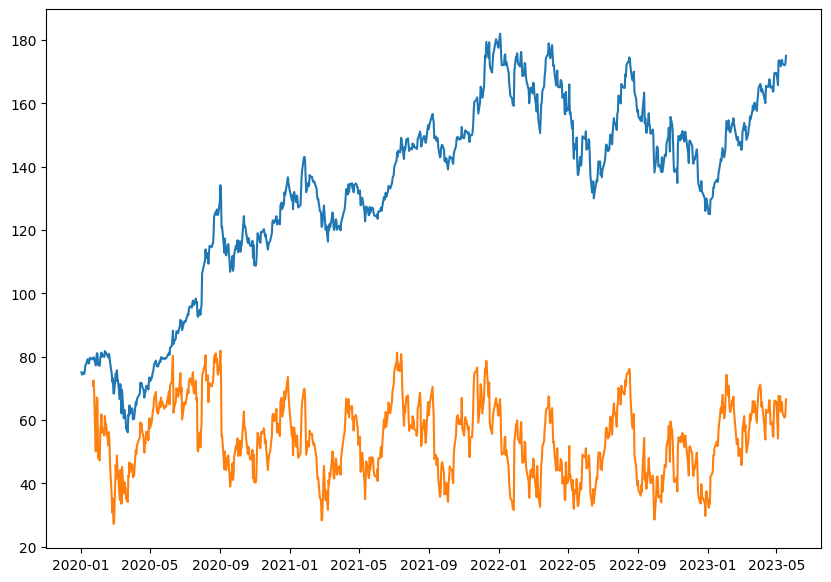

In [10]:
plt.figure(figsize=(10,7))
plt.plot(ind_data)

In [32]:
fig = px.line(ind_data)
fig.show()


In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.065, shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['Close'], name = 'Close price'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['RSI'], name = 'RSI'),
    row=2, col=1
)

fig.update_layout(height = 600)
fig.show()